In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

##### 为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。 在下面的代码中，我们生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # normal(均值, 标准差, 张量大小)
    y = torch.matmul(X, w) + b # matrix multiplication 涵盖了.mm & .mv, 并且可以批量操作
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) # features 大小为(1000,2)

In [3]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.8528,  0.4087]) 
label: tensor([1.0961])


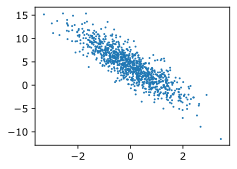

In [14]:
d2l.set_figsize()
# d2l.plt.scatter(x, y, s=点的大小)
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

##### 有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 获取样本数量
    indices = list(range(num_examples)) # 创建样本索引列表
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # 按照 batchsize 切分样本
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices] # 返回这一组编号的feature和label
# 注意, return只会返回一次, 而yield可以让函数变成生成器，跑一遍返回一个

In [6]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.4714, -1.3226],
        [-0.6040, -0.6509],
        [-2.8598, -1.5873],
        [-0.7133,  0.7686],
        [-1.8361, -0.2522],
        [ 1.1636, -1.1754],
        [-0.4110, -0.0114],
        [-1.2585, -0.4032],
        [-0.8767,  0.3747],
        [ 1.1089, -1.5693]]) 
 tensor([[ 7.7541],
        [ 5.2004],
        [ 3.8911],
        [ 0.1590],
        [ 1.3964],
        [10.5055],
        [ 3.4403],
        [ 3.0461],
        [ 1.1699],
        [11.7615]])


##### 初始化模型参数.我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [7]:
w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad=True)
w,b

(tensor([[-0.0072],
         [-0.0035]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [8]:
def linreg(X, w, b): #@save
    # 线性回归, reg --- regression
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y): #@save
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [10]:
def sgd(params, lr, batch_size): #@save
    # 小批量随机梯度下降, stochastic gradient descent
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

##### 我们要执行的循环是1.初始化参数 2.重复34 3.计算梯度 4.更新参数

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # x and y 的小批量损失 , l的size为(batchsize,1)
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad(): # 每一个epoch更新完后计算一下损失
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043904
epoch 2, loss 0.000174
epoch 3, loss 0.000048


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0008, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)
